# cs109a Final Project Milestone 3: EDA

In [6]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_encounters = pd.read_csv('../data/diabetic_data.csv', 
                            na_values='?',
                            low_memory=False #silence the mixed dtypes warning
                           )
df_encounters.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Exploratory data analysis

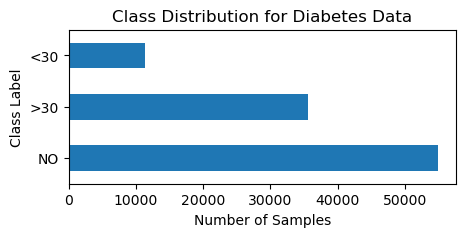

In [8]:
# visualize class imbalance
plt.figure(figsize=(5, 2))
df_encounters['readmitted'].value_counts().plot(kind='barh')
plt.title('Class Distribution for Diabetes Data')
plt.ylabel('Class Label')
plt.xlabel('Number of Samples');

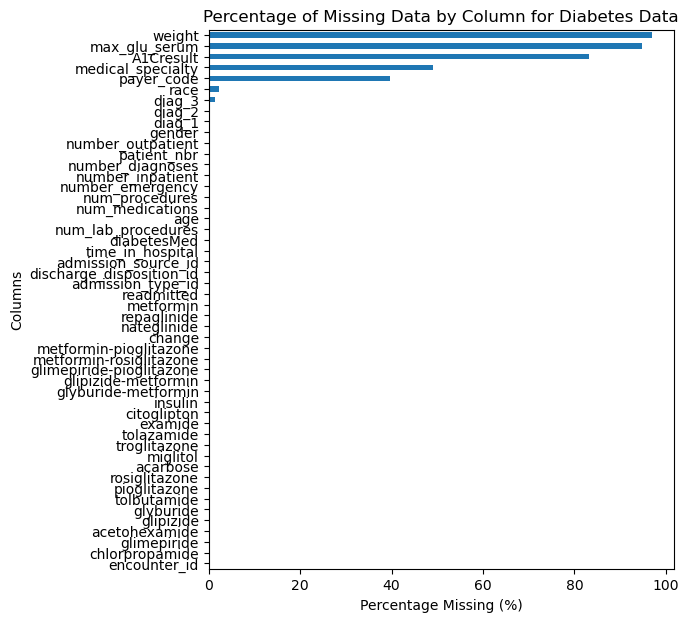

In [11]:
# calculate missing data percentages
missing_data_percentage = (df_encounters.isnull().sum() / len(df_encounters)) * 100
missing_data_percentage = missing_data_percentage.sort_values(ascending=True)

plt.figure(figsize=(6, 7))
missing_data_percentage.plot(kind='barh')
plt.title('Percentage of Missing Data by Column for Diabetes Data')
plt.xlabel('Percentage Missing (%)')
plt.ylabel('Columns');

In [14]:
# missing values table
missing_values = df_encounters.isnull().sum()
missing_percentage = (100 * df_encounters.isnull().sum() / len(df_encounters))
missing_values_table = pd.concat([missing_values, missing_percentage], axis=1)
    
missing_values_table = missing_values_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
missing_values_table = missing_values_table[
    missing_values_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
print(f"The diabetes data have " + str(df_encounters.shape[1]) + " columns.\n"      
    "There are " + str(missing_values_table.shape[0]) +
    " columns that have missing values.\n")

print(missing_values_table)

The diabetes data have 50 columns.
There are 9 columns that have missing values.

                   Missing Values  % of Total Values
weight                      98569               96.9
max_glu_serum               96420               94.7
A1Cresult                   84748               83.3
medical_specialty           49949               49.1
payer_code                  40256               39.6
race                         2273                2.2
diag_3                       1423                1.4
diag_2                        358                0.4
diag_1                         21                0.0


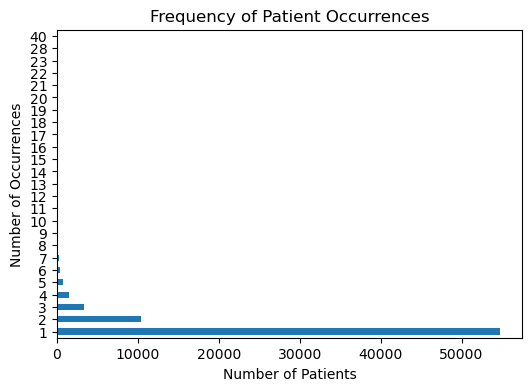

In [15]:
# calculate the frequency of each 'patient_id'
id_counts = df_encounters['patient_nbr'].value_counts()
# count how many 'patient_id's occur for each frequency
frequency_counts = id_counts.value_counts().sort_index()

plt.figure(figsize=(6,4))
frequency_counts.plot(kind='barh')
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Patients')
plt.title('Frequency of Patient Occurrences');

In [18]:
# group by 'patient_id' and filter out those with only one encounter
multiple_encounters = df_encounters.groupby('patient_nbr').filter(lambda x: len(x) > 1)
print(f"Total number of patients with multple encounters: {multiple_encounters['patient_nbr'].nunique()}")

Total number of patients with multple encounters: 16773


Total number of patients with different outcomes across encounters: 2766



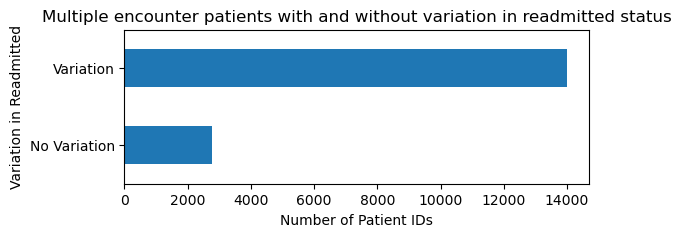

In [22]:
# check if 'readmitted' values vary within each group
def check_variation(df):
    return df['readmitted'].nunique() > 1

variation = multiple_encounters.groupby('patient_nbr').apply(check_variation)

variation_counts = variation.astype(int).value_counts().sort_index()

print(f"Total number of patients with different outcomes across encounters: {variation.value_counts()[1]}\n")

plt.figure(figsize=(6,2))
variation_counts.plot(kind='barh')
plt.xlabel('Number of Patient IDs')
plt.ylabel('Variation in Readmitted')
plt.title('Multiple encounter patients with and without variation in readmitted status')
plt.yticks(ticks=[0, 1], labels=['No Variation', 'Variation']);

In [24]:
# age
df_encounters['age'].value_counts(normalize=True) * 100

age
[70-80)     25.615628
[60-70)     22.092840
[50-60)     16.956547
[80-90)     16.898571
[40-50)      9.516931
[30-40)      3.709490
[90-100)     2.744532
[20-30)      1.628245
[10-20)      0.679009
[0-10)       0.158206
Name: proportion, dtype: float64

In [25]:
# gender
df_encounters['gender'].value_counts(normalize=True) * 100

gender
Female             53.758623
Male               46.238429
Unknown/Invalid     0.002948
Name: proportion, dtype: float64

In [26]:
# race
df_encounters['race'].value_counts(normalize=True) * 100

race
Caucasian          76.486788
AfricanAmerican    19.307891
Hispanic            2.047380
Other               1.513674
Asian               0.644266
Name: proportion, dtype: float64

## Recode and/or collapse some of the categorical features

In [27]:
#weight has majority values missing
#payer_code has some missing values and is not relevant to response
df_encounters.drop(['weight','payer_code'],axis=1,inplace=True)

#collapse age based on frequency of occurrence and response
df_encounters['age'].replace({'[0-10)' :'[0-50)',
                              '[10-20)':'[0-50)',
                              '[20-30)':'[0-50)',
                              '[30-40)':'[0-50)',
                              '[40-50)':'[0-50)',
                              '[80-90)':'[80-100)',
                              '[90-100)':'[80-100)'},
                              inplace=True)

df_encounters.race.fillna('UNK',inplace=True)

df_encounters['admission_type_id'] = df_encounters['admission_type_id'].apply(lambda id: 0 if id >=4 else id)
df_encounters.admission_type_id.replace({0:'Other',1:'Emergency',2:'Urgent',3:'Elective'},
                                        inplace=True)

df_encounters.loc[~df_encounters['admission_source_id'].isin([1,7]) , 'admission_source_id'] = 0
df_encounters.admission_source_id.replace({0:'Other',1:'Physician Referral',7:'Emergency Room'},
                                           inplace=True)


#remove patients transferred to hospice or those that died
df_encounters = df_encounters[~df_encounters.discharge_disposition_id.isin([11,13,14,19,20,21])]
#collapse unimportant ones
df_encounters['discharge_disposition_id']=df_encounters['discharge_disposition_id'].apply(lambda id: \
                                                                                          id if id in [1,3,6]
                                                                                          else 0)
df_encounters.discharge_disposition_id.replace({0:'Other',1:'Home',3:'SNF',6:'Home w/ Service'},
                                               inplace=True)

frequent_specialties = ['InternalMedicine','Emergency/Trauma','Family/GeneralPractice','Cardiology',
                        'Surgery-General','Nephrology','Orthopedics','Orthopedics-Reconstructive','Radiologist']
df_encounters.loc[~df_encounters['medical_specialty'].isin(frequent_specialties) , 
                  'medical_specialty'] = 'Other'
df_encounters.loc[df_encounters['medical_specialty'].isin(['Orthopedics','Orthopedics-Reconstructive']), 
                  'medical_specialty'] = 'Orthopedics'

df_encounters['readmitted'].replace({'<30':1,'NO':0,'>30':0},inplace=True)
df_encounters['diabetesMed'].replace({'Yes':1,'No':0},inplace=True)
df_encounters['change'].replace({'Ch':1,'No':0},inplace=True)


df_encounters['a1c_result_high'] = df_encounters['A1Cresult'].fillna(0).replace({'>8':1,'Norm':0,'>7':0})
df_encounters['A1Cresult'].fillna('UNK',inplace=True)


df_encounters['max_glu_serum_high'] = df_encounters['max_glu_serum'].fillna(0).replace({'>300':1,
                                                                                        'Norm':0,
                                                                                        '>200':0})
df_encounters['max_glu_serum'].fillna('UNK',inplace=True) #not measured


## Process the diagnosis codes

In [29]:
group_to_code_patterns = dict()
group_to_code_patterns['diabetes']=r'250\..*'
group_to_code_patterns['circulatory']=r'(39[0-9])|(45[0-9])|(785)'
group_to_code_patterns['respiratory']=r'(4[6-9][0-9])|(5[0-1][0-9])|(786)'
group_to_code_patterns['digestive']=r'(5[2-7][0-9])|(787)'
group_to_code_patterns['injury']=r'([8|9][0-9][0-9])'
group_to_code_patterns['musculoskeletal']=r'(7[1-3][0-9])'
group_to_code_patterns['genitournary']=r'(5[8-9][0-9])|(6[0-2][0-9])|(788)'
group_to_code_patterns['neoplasms']=r'(1[4-9][0-9])|(2[0-9][0-9])|(78(0|1|4))|(79[0-9])|(2[4-7][0-9])|(6[8-9][0-9])|(70[0-9])|(782)'
group_to_code_patterns['other']=r'(V[0-9]+)|([0-9]+)'

for diag in ['diag_1','diag_2','diag_3']:
    df_encounters[diag].fillna('UNK',inplace=True)
    for group,pattern in group_to_code_patterns.items():
        df_encounters[diag]=df_encounters[diag].str.replace(pattern,group,regex=True)
    #print to check
    display(df_encounters[diag].value_counts().sort_index())
    print()


diag_1
Einjury                1
UNK                   20
circulatory         1504
diabetes            8426
digestive           9333
genitournary        5002
injury              6853
musculoskeletal     4935
neoplasms          14082
other              35253
respiratory        13934
Name: count, dtype: int64

diag_2
Einjury              727
UNK                  356
circulatory         1459
diabetes            6654
digestive           4088
genitournary        8147
injury              2385
musculoskeletal     1761
neoplasms          26334
other              37042
respiratory        10390
Name: count, dtype: int64

diag_3
Einjury             1237
UNK                 1419
circulatory         1526
diabetes            5513
digestive           3857
genitournary        6436
injury              1898
musculoskeletal     1898
neoplasms          30460
other              38093
other.other            1
respiratory         7005
Name: count, dtype: int64

## Create derived variables

## Aggregate multiple encounter data to the patient-level

In [30]:
# get only the last encounter for each patient
df_patient_by_last_encounter = df_encounters.groupby('patient_nbr').last()

In [31]:
#aggregate encounter history for each patient

df_patient_encounter = df_encounters.groupby('patient_nbr') \
                                    .agg({'encounter_id':'nunique', 
                                          'time_in_hospital':['mean','min','max'],
                                          'num_lab_procedures':['mean','min','max'],
                                          'num_procedures': ['mean','min','max'],
                                          'num_medications':['mean','min','max'],
                                          'number_diagnoses':['mean','min','max'],
                                          'max_glu_serum':['nunique'],
                                          'max_glu_serum_high':['mean','sum','all','any'],
                                          'A1Cresult':'nunique',
                                          'a1c_result_high':['mean','sum','all','any'],
                                          'change':['mean','sum','all','any'],
                                          'diabetesMed': ['mean','sum','all','any'],
                                          'readmitted': ['mean','sum','all','any']})

aggr_cols = ['num_encounters',
             'avg_time_in_hospital','min_time_in_hospital','max_time_in_hospital',
             'avg_num_lab_procedures','min_num_lab_procedures','max_num_lab_procedures',
             'avg_num_procedures','min_num_procedures','max_num_procedures',
             'avg_num_medications','min_num_medications','max_num_medications',
             'mean_diagnoses','min_diagnoses','max_diagnoses',
             'unique_glu_measurements',
             'avg_times_glu_high','num_times_glu_high','glu_always_high','glu_ever_high',
             'unique_a1c_results',
             'avg_times_a1c_high','num_times_a1c_high','a1c_always_high','a1c_ever_high',
             'avg_times_med_changed','num_times_med_changed','med_always_changed','med_ever_changed',
             'avg_times_diabetic_med_prescribed','num_times_diabetic_med_prescribed',
             'diabetic_med_always_prescribed', 'diabetic_med_ever_prescribed',
             'avg_times_readmitted','num_times_readmitted','always_readmitted','ever_readmitted']
df_patient_encounter.columns = aggr_cols

for col in df_patient_encounter.select_dtypes(bool):
    df_patient_encounter[col] = df_patient_encounter[col].astype(int)

df_patient_by_last_encounter = df_patient_by_last_encounter.merge(df_patient_encounter,on='patient_nbr')

#no use for encounter_id or the two other temp columns anymore
df_patient_by_last_encounter.drop(['encounter_id','a1c_result_high','max_glu_serum_high'],axis=1,inplace=True)

df_patient_by_last_encounter.shape

(69990, 84)

In [32]:
# no missing response values
assert sum(df_patient_by_last_encounter['readmitted'].isna()) == 0
# no missing values in predictors
assert df_patient_by_last_encounter.isna().sum().sum() == 0

In [34]:
df_patient_by_last_encounter.to_csv('../data/diabetic_data_processed.csv')